In [1]:
import tensorflow.compat.v1 as tf
from tensorflow.compat.v1 import InteractiveSession
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
from numpy import *
import os
import numpy as np
import time

from scipy.misc import imread
from scipy.misc import imresize
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
from scipy.ndimage import filters
import urllib
from numpy import random
from caffe_classes import class_names

##ADD 
from os import listdir
from os.path import isfile, join
from random import sample
from numpy import random

from PIL import Image

import glob

In [2]:
def next_batch(batch_size):
    path = os.getcwd()
    trainPath = path + "/TrainSet/"
    files = [f for f in listdir(trainPath) if isfile(join(trainPath, f))]
    #print(files)
    files = sample(files, len(files))
    batch_x = np.ndarray([batch_size,227, 227, 3])
    batch_y = np.zeros((batch_size, 2))
    i = 0
    l = 0
    for fname in files:
        #fname = fname.replace('._','')
        #print("work"+ fname+str(l))
        img = (imread(join(trainPath, fname))[:,:,:3]).astype(float32)
        l = l+1
        img = img - mean(img)
        img = imresize(img, (227,227,3), interp='bilinear', mode=None)
        batch_x[i] = img
        if "horse" in fname:
            batch_y[i][0] = 1
        if "cebra" in fname:
            batch_y[i][1] = 1
        i+=1
        if i == batch_size:
            yield (batch_x, batch_y)
            batch_x = np.ndarray([batch_size,227, 227, 3])
            batch_y = np.zeros((batch_size, 3))
            i=0

In [3]:
#Define the output number of classes : dogs and cats
n_classes = 2

train_x = zeros((1, 227,227,3)).astype(float32)
train_y = zeros((1, n_classes))
print(train_x.shape)
xdim = train_x.shape[1:]
ydim = train_y.shape[1]

#ADD
learning_rate = 0.02
x = tf.placeholder(tf.float32, (None,) + xdim) # None = number of input images
y = tf.placeholder(tf.float32, [None,ydim])
keep_prob = tf.placeholder(tf.float32) #dropout (keep probability)

path = os.getcwd()
testPath1 = path + "/TestSet/"
imlist = []
for i in range (100):
    filename = testPath1 + str(i)+".jpg"
    im = (imread(str(filename))[:,:,:3]).astype(float32)
    im = im - mean(im)
    imlist.append(im)

net_data = load(open("bvlc_alexnet.npy", "rb"), encoding="latin1").item()

(1, 227, 227, 3)


/home/fastpumpkin/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


In [4]:
def conv(input, kernel, biases, k_h, k_w, c_o, s_h, s_w,  padding="VALID", group=1):
    c_i = input.get_shape()[-1]
    assert c_i%group==0
    assert c_o%group==0
    convolve = lambda i, k: tf.nn.conv2d(i, k, [1, s_h, s_w, 1], padding=padding)
    
    if group==1:
        conv = convolve(input, kernel)
    else:
        input_groups =  tf.split(input, group, 3)   #tf.split(3, group, input)
        kernel_groups = tf.split(kernel, group, 3)  #tf.split(3, group, kernel) 
        output_groups = [convolve(i, k) for i,k in zip(input_groups, kernel_groups)]
        conv = tf.concat(output_groups, 3)          #tf.concat(3, output_groups)
    return  tf.reshape(tf.nn.bias_add(conv, biases), [-1]+conv.get_shape().as_list()[1:])


In [5]:
#conv1
#conv(11, 11, 96, 4, 4, padding='VALID', name='conv1')
k_h = 11; k_w = 11; c_o = 96; s_h = 4; s_w = 4
conv1W = tf.Variable(net_data["conv1"][0])
conv1b = tf.Variable(net_data["conv1"][1])
conv1_in = conv(x, conv1W, conv1b, k_h, k_w, c_o, s_h, s_w,padding="SAME",group=1)
conv1 = tf.nn.relu(conv1_in)

#lrn1
#lrn(2, 2e-05, 0.75, name='norm1')
radius = 2; alpha = 2e-05; beta = 0.75; bias = 1.0
lrn1 = tf.nn.local_response_normalization(conv1,depth_radius=radius,alpha=alpha,beta=beta,bias=bias)

#maxpool1
#max_pool(3, 3, 2, 2, padding='VALID', name='pool1')
k_h = 3; k_w = 3; s_h = 2; s_w = 2; padding = 'VALID'
maxpool1 = tf.nn.max_pool(lrn1, ksize=[1, k_h, k_w, 1], strides=[1, s_h, s_w, 1],padding=padding)

#conv2
#conv(5, 5, 256, 1, 1, group=2, name='conv2')
k_h = 5; k_w = 5; c_o = 256; s_h = 1; s_w = 1; group = 2
conv2W = tf.Variable(net_data["conv2"][0])
conv2b = tf.Variable(net_data["conv2"][1])
conv2_in = conv(maxpool1, conv2W, conv2b, k_h, k_w, c_o, s_h, s_w,padding="SAME",group=group)
conv2 = tf.nn.relu(conv2_in)

#lrn2
#lrn(2, 2e-05, 0.75, name='norm2')
radius = 2; alpha = 2e-05; beta = 0.75; bias = 1.0
lrn2 = tf.nn.local_response_normalization(conv2,depth_radius=radius,alpha=alpha,beta=beta,bias=bias)

#maxpool2
#max_pool(3, 3, 2, 2, padding='VALID', name='pool2')                                                  
k_h = 3; k_w = 3; s_h = 2; s_w = 2; padding = 'VALID'
maxpool2 = tf.nn.max_pool(lrn2, ksize=[1, k_h, k_w, 1], strides=[1, s_h, s_w, 1],padding=padding)

#conv3
#conv(3, 3, 384, 1, 1, name='conv3')
k_h = 3; k_w = 3; c_o = 384; s_h = 1; s_w = 1; group = 1
conv3W = tf.Variable(net_data["conv3"][0])
conv3b = tf.Variable(net_data["conv3"][1])
conv3_in = conv(maxpool2, conv3W, conv3b, k_h, k_w, c_o, s_h, s_w, padding="SAME",group=group)
conv3 = tf.nn.relu(conv3_in)

#conv4
#conv(3, 3, 384, 1, 1, group=2, name='conv4')
k_h = 3; k_w = 3; c_o = 384; s_h = 1; s_w = 1; group = 2
conv4W = tf.Variable(net_data["conv4"][0])
conv4b = tf.Variable(net_data["conv4"][1])
conv4_in = conv(conv3, conv4W, conv4b, k_h, k_w, c_o, s_h, s_w, padding="SAME",group=group)
conv4 = tf.nn.relu(conv4_in)


#conv5
#conv(3, 3, 256, 1, 1, group=2, name='conv5')
k_h = 3; k_w = 3; c_o = 256; s_h = 1; s_w = 1; group = 2
conv5W = tf.Variable(net_data["conv5"][0])
conv5b = tf.Variable(net_data["conv5"][1])
conv5_in = conv(conv4, conv5W, conv5b, k_h, k_w, c_o, s_h, s_w, padding="SAME",group=group)
conv5 = tf.nn.relu(conv5_in)

#maxpool5
#max_pool(3, 3, 2, 2, padding='VALID', name='pool5')
k_h = 3; k_w = 3; s_h = 2; s_w = 2; padding = 'VALID'
maxpool5 = tf.nn.max_pool(conv5, ksize=[1, k_h, k_w, 1], strides=[1, s_h, s_w, 1], padding=padding)

#fc6
#fc(4096, name='fc6')
fc6W = tf.Variable(net_data["fc6"][0])
fc6b = tf.Variable(net_data["fc6"][1])
fc6 = tf.nn.relu_layer(tf.reshape(maxpool5, [-1, int(prod(maxpool5.get_shape()[1:]))]), fc6W, fc6b)

#fc7
#fc(4096, name='fc7')
fc7W = tf.Variable(net_data["fc7"][0])
fc7b = tf.Variable(net_data["fc7"][1])
fc7 = tf.nn.relu_layer(fc6, fc7W, fc7b)

#fc8
#fc(1000, relu=False, name='fc8')

#comment these two following lines
#fc8W = tf.Variable(net_data["fc8"][0])
#fc8b = tf.Variable(net_data["fc8"][1])

#Define the variables for the last fully connected layer. Aqui se trunca la capa anterior a 2 unidades de salida
fc8W = tf.Variable(tf.random_normal([4096, n_classes]),trainable=True, name="fc8w")
fc8b = tf.Variable(tf.random_normal([n_classes]),trainable=True, name="fc8b")
#end

fc8 = tf.nn.xw_plus_b(fc7, fc8W, fc8b)

#prob
#softmax(name='prob'))
prob = tf.nn.softmax(fc8)

#ADD
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=prob, labels=y))
opt_vars = [v for v in tf.trainable_variables() if (v.name.startswith("fc8"))]
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss,var_list=opt_vars)

# Evaluation
correct_pred = tf.equal(tf.argmax(prob, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
                                                    
batch_size = 100
training_iters = 10000 
display_step = 1
dropout = 0.85 # Dropout, probability to keep units



/home/fastpumpkin/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  
/home/fastpumpkin/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


Iter 100, Minibatch Loss= 0.938265, Training Accuracy= 0.37000
Iter 200, Minibatch Loss= 0.847353, Training Accuracy= 0.47000
Iter 300, Minibatch Loss= 0.844155, Training Accuracy= 0.47000
Iter 400, Minibatch Loss= 0.786145, Training Accuracy= 0.52000
Iter 500, Minibatch Loss= 0.565048, Training Accuracy= 0.74000
Iter 600, Minibatch Loss= 0.554249, Training Accuracy= 0.76000
Iter 700, Minibatch Loss= 0.435729, Training Accuracy= 0.88000
Iter 800, Minibatch Loss= 0.428190, Training Accuracy= 0.89000
Iter 900, Minibatch Loss= 0.430233, Training Accuracy= 0.88000
Iter 1000, Minibatch Loss= 0.433433, Training Accuracy= 0.88000
Iter 1100, Minibatch Loss= 0.424428, Training Accuracy= 0.89000
Iter 1200, Minibatch Loss= 0.460956, Training Accuracy= 0.85000
Iter 1300, Minibatch Loss= 0.440162, Training Accuracy= 0.87000
Iter 1400, Minibatch Loss= 0.433261, Training Accuracy= 0.88000
Iter 1500, Minibatch Loss= 0.441753, Training Accuracy= 0.87000
Iter 1600, Minibatch Loss= 0.352904, Training Acc

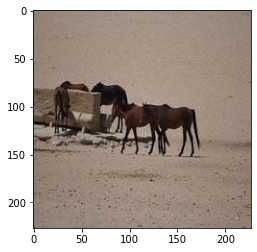

prevision is a horse


In [6]:
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    step = 1
    # Keep training until reach max iterations
    while step * batch_size < training_iters:
        batch_x, batch_y = next(next_batch(batch_size)) #.next()
        # Run optimization op (backprop)        
        sess.run(optimizer, feed_dict={x: batch_x,y: batch_y,keep_prob: dropout})                                
        if step % display_step == 0:
            # Calculate batch loss and accuracy
            cost, acc = sess.run([loss, accuracy],feed_dict={x: batch_x,y: batch_y,keep_prob: 1.})
            print ("Iter " + str(step*batch_size)+", Minibatch Loss= "+"{:.6f}".format(cost)+", Training Accuracy= "+"{:.5f}".format(acc))              
        step += 1
    print ("Optimization Finished!")
    # Gato = 0, Perro = 1 
    output = sess.run(prob, feed_dict = {x:imlist, keep_prob: 1.})
    result = np.argmax(output,1)

    testResult = [1,0,1,0,1,0,0,0,0,1,\
                0,0,0,0,0,1,1,0,0,0,\
                0,1,1,1,0,0,0,1,0,0,\
                0,1,0,1,1,1,1,1,1,1,\
                0,1,1,1,1,0,1,1,0,1,\
                0,1,1,1,1,1,1,0,0,1,\
                1,1,0,1,1,0,0,1,0,0,\
                0,0,1,1,0,1,0,1,0,1,\
                1,0,1,0,1,1,0,0,0,0,\
                0,1,1,1,0,0,1,0,0,1]



    count = 0
    vec = [];
    for i in range(0,99):
        if result[i] == testResult[i]:
            count=count+1
        vec.append(result[i])

    print("Testing Accuracy = " + str(count) +"%")
    print(vec[0:9])
    print(vec[10:19])
    print(vec[20:29])
    print(vec[30:39])
    print(vec[40:49])
    print(vec[50:59])
    print(vec[60:69])
    print(vec[70:79])
    print(vec[80:89])
    print(vec[90:99])



    from random import randint
    j = randint(0, 99)
    filename = testPath1 + str(j)+".jpg"


    import matplotlib.image as mpimg
    image = mpimg.imread(filename)
    plt.imshow(image)
    plt.show()
    
    if result[j]== 0 :
        print("prevision is a horse")
    else:
        print("prevision is a zebra")
